In [1]:
%load_ext autoreload
%autoreload 2

# Test ID Mgmt Service

In [65]:
from typing import List
import random
import time
import inspect
from mcp.client.sse import sse_client
from mcp import ClientSession
import logging

logging.basicConfig(level=logging.ERROR)

mapping = {
    "fid": "gen_fid",
    "oid": "gen_oid",
    "tid": "gen_tid"
}

MCP_URL = "http://127.0.0.1:8000/sse"

async def gen_id(type:str)->str:
    """generate a MeMo ID
    Args:
        type (str): type of id to generate. Valid values are 'fid', 'oid', 'tid'
    Returns:
        id (str): the generated ID 
    """
    tool_name = mapping[type]
    async with sse_client(url=MCP_URL) as streams:
        async with ClientSession(*streams) as session:
            await session.initialize()
            response = await session.call_tool(tool_name)
            if response.isError:
                print(f"\t💥 Error in gen_id {response}")
                raise RuntimeError(response.content[0].text)
            
            id = response.content[0].text
            return id
        
async def gen_tids(quantity:int)->List[str]:
    """generate a MeMo ID
    Args:
        quantity (int): number of TIDs to generate. valid range is 1 to 100 (inclusive).
    Returns:
        ids (List[str]): the list of generated TIDs 
    """
    async with sse_client(url=MCP_URL) as streams:
        ids = []
        async with ClientSession(*streams) as session:
            await session.initialize()
            response = await session.call_tool("gen_tids",  arguments={"quantity": quantity})
            if response.isError:
                print(f"\t💥 error in gen_tids {response}")
                raise RuntimeError(response.content[0].text)
            
            ids = [content.text for content in response.content]
            return ids
    

In [66]:
import asyncio

tasks = [
    gen_id('fid'),
    gen_id('oid'),
    gen_id('tid')
]
fid, oid, tid =  await asyncio.gather(*tasks)

print(f"{fid=}, {oid=}, {tid=}")

fid='6113289634', oid='471181848132096', tid='ZTL4ZJ00'


In [70]:
tids = await asyncio.gather(gen_tids(3))
tids

[['XHEQDS00', 'XHEQDS01', 'XHEQDS02']]

In [71]:
tids_task = asyncio.create_task(gen_tids(3))
tids = await tids_task
print(tids)

['6IC7YQ00', '6IC7YQ01', '6IC7YQ02']


In [72]:
tids = await gen_tids(500)

	💥 error in gen_tids meta=None content=[TextContent(type='text', text='Error executing tool gen_tids: 1 validation error for gen_tidsArguments\nquantity\n  Input should be less than or equal to 100 [type=less_than_equal, input_value=500, input_type=int]\n    For further information visit https://errors.pydantic.dev/2.11/v/less_than_equal', annotations=None)] isError=True


  + Exception Group Traceback (most recent call last):
  |   File "C:\Users\lawr1\AppData\Roaming\Python\Python313\site-packages\IPython\core\interactiveshell.py", line 3670, in run_code
  |     await eval(code_obj, self.user_global_ns, self.user_ns)
  |   File "C:\Users\lawr1\AppData\Local\Temp\ipykernel_37900\194585052.py", line 1, in <module>
  |     tids = await gen_tids(500)
  |            ^^^^^^^^^^^^^^^^^^^
  |   File "C:\Users\lawr1\AppData\Local\Temp\ipykernel_37900\325359092.py", line 45, in gen_tids
  |     async with sse_client(url=MCP_URL) as streams:
  |                ~~~~~~~~~~^^^^^^^^^^^^^
  |   File "c:\Program Files\Python313\Lib\contextlib.py", line 235, in __aexit__
  |     await self.gen.athrow(value)
  |   File "C:\Users\lawr1\AppData\Roaming\Python\Python313\site-packages\mcp\client\sse.py", line 54, in sse_client
  |     async with anyio.create_task_group() as tg:
  |                ~~~~~~~~~~~~~~~~~~~~~~~^^
  |   File "C:\Users\lawr1\AppData\Roaming\Python\Pyt

# Test Workflows

In [73]:
import time
from faker import Faker
from datetime import datetime
from workflow_mgmt import workflow_defn, workstep_defn
from workflow_mgmt import ExponentialJitterRetryPolicy, LinearRetryPolicy

fake = Faker("en_AU")
gen_tid = lambda: fake.bothify(text="?"*6+"00", letters='0123456789')  #'ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789')
gen_tids = lambda quantity: [gen_tid() for _ in range(quantity)]

fake_data = {
    "customer": {
        "id": fake.iban(),
        "name": fake.company(),
        "address": fake.address(),
    },
    "merchant": {
        "mid": "53531090"+fake.ean8(),
        "product_code": "MVM",
        "trading_address": fake.address(),
        "pricing": {
            "plan": "SRPT",
            "negotiated": False,
        },
        "terminals": {
            # "tids": ["12345600", "12345601", "12345602"],
            "tids": gen_tids(3),
            "parameters": {
                "refund_limit": 100,
                "mcr": {
                    "enabled": False
                }
            }
        }
    }
}

In [74]:
print(fake_data)

{'customer': {'id': 'GB18BQKA17141063684034', 'name': 'Rodriguez-Spencer', 'address': '57 Lopez Roadway\nCharleshaven, ACT, 2920'}, 'merchant': {'mid': '5353109043821969', 'product_code': 'MVM', 'trading_address': '596 Green Formation\nPort Lisaside, ACT, 2815', 'pricing': {'plan': 'SRPT', 'negotiated': False}, 'terminals': {'tids': ['50271600', '49026400', '86202700'], 'parameters': {'refund_limit': 100, 'mcr': {'enabled': False}}}}}


## sync workflow

In [5]:
import copy
from mock_services import MafService, IpbService, CtaService, CpsdService

@workflow_defn(
    retry_policy=ExponentialJitterRetryPolicy(max_retries=3, base_delay=1.0, exclude_exceptions=[ValueError])
)
class EssentialLite_Replacement_Workflow:
    def __init__(self, data):
        self.data = data
        self.processed_data = copy.deepcopy(data)
    
    def execute(self):
        """Main workflow execution method"""
        # Create work steps - they will inherit workflow retry policy
        results = []

        MafService.onboard_merchant.step_id = "Step_1"
        results.append(MafService.onboard_merchant(self.processed_data))

        CpsdService.link_customer_product.step_id = "Step_2"
        results.append(CpsdService.link_customer_product(self.processed_data))
        results.append(IpbService.onboard_merchant(self.processed_data))
        results.append(CtaService.onboard_merchant(self.processed_data))

        return results
    
transition_wf = EssentialLite_Replacement_Workflow(fake_data)
transition_wf.execute()
        

#### 🚀 Starting sync workflow EssentialLite_Replacement_Workflow with retry policy: ExponentialJitterRetryPolicy
	...Inheriting workflow retry policy: ExponentialJitterRetryPolicy
  ## 🚀 Executing work step in workflow: Step_1
  ## 👣 Step Step_1: Starting execution with ExponentialJitterRetryPolicy (max_retries=3)
	Step Step_1: Attempt 1
	onboarding new merchant: {'customer': {'id': 'GB78UCDM05312532634082', 'name': 'Ward LLC', 'address': '6 Hunt Causeway\nNorth Carlos, TAS, 2619'}, 'merchant': {'mid': '5353109010123456', 'product_code': 'MVM', 'trading_address': '6 Jones Little\nRichardsonbury, TAS, 0216', 'pricing': {'plan': 'SRPT', 'negotiated': False}, 'terminals': {'tids': ['81558300', '92753500', '08586900'], 'parameters': {'refund_limit': 100, 'mcr': {'enabled': False}}}}}
	MafService successful!
  #v ✅ Step Step_1: Completed successfully on attempt 1
	...Inheriting workflow retry policy: ExponentialJitterRetryPolicy
  ## 🚀 Executing work step in workflow: Step_2
  ## 👣 Step Ste

ValueError: Wrong customer or merchant data, go fix it.

## async worflow

In [37]:
import copy
import inspect
from mock_services import IdService, MafService, IpbService, CtaService, CpsdService

@workflow_defn(
    retry_policy=ExponentialJitterRetryPolicy(max_retries=3, base_delay=1.0, exclude_exceptions=[ValueError])
)
class async_EssentialLite_Replacement_Workflow:
    def __init__(self, data):
        self.data = data
        self.processed_data = copy.deepcopy(data)
    
    async def execute(self):
        """Main workflow execution method"""
        
        # allocate MeMo IDs
        fid = await IdService.gen_id("fid")
        oid = await IdService.gen_id("oid")
        old_tids = self.data['merchant']['terminals']['tids']
        tids = await IdService.gen_tids(len(old_tids))

        # enrich json payload
        self.processed_data['customer']['fid'] = fid
        self.processed_data['merchant']['oid'] = oid
        self.processed_data['merchant']['new_product_code'] = fake.ean8()
        self.processed_data['merchant']['terminals']['new_tids'] = tids
        
        # Create work steps - they will inherit workflow retry policy
        results = []
        results.append(MafService.onboard_merchant(self.processed_data))
        results.append(CpsdService.link_customer_product(self.processed_data))

        IpbService.onboard_merchant.step_id = "Step 3 - IPB"
        results.append(IpbService.onboard_merchant(self.processed_data))

        CtaService.onboard_merchant.step_id = "Step 4 - CTA"
        results.append(CtaService.onboard_merchant(self.processed_data))

        return results
        
transition_wf = async_EssentialLite_Replacement_Workflow(fake_data)
await transition_wf.execute()

#### 🚀 Starting async workflow async_EssentialLite_Replacement_Workflow with retry policy: ExponentialJitterRetryPolicy
	...Using explicit step retry policy: LinearRetryPolicy
  ## 🚀 Executing work step in workflow: GenMeMoId
  ## 👣 Step GenMeMoId: Starting execution with LinearRetryPolicy (max_retries=3)
	Step GenMeMoId: Attempt 1
  #v ✅ Step GenMeMoId: Completed successfully on attempt 1
	...Using explicit step retry policy: LinearRetryPolicy
  ## 🚀 Executing work step in workflow: GenMeMoId
  ## 👣 Step GenMeMoId: Starting execution with LinearRetryPolicy (max_retries=3)
	Step GenMeMoId: Attempt 1
  #v ✅ Step GenMeMoId: Completed successfully on attempt 1
	...Using explicit step retry policy: LinearRetryPolicy
  ## 🚀 Executing work step in workflow: GenTids
  ## 👣 Step GenTids: Starting execution with LinearRetryPolicy (max_retries=3)
	Step GenTids: Attempt 1
  #v ✅ Step GenTids: Completed successfully on attempt 1
	...Inheriting workflow retry policy: ExponentialJitterRetryPolicy
  

ValueError: Wrong customer or merchant data, go fix it.

In [8]:
import threading
_context = threading.local()
getattr(_context, 'workflow_context', None)

# Workflow DB

In [38]:
from sqlalchemy import text
from workflow_mgmt import Session

session = Session()

In [23]:
session.close()

## DDL

In [15]:
import duckdb

# conn = duckdb.connect('db/workflow.db')
conn = session.connection().connection.driver_connection

# Get all table names
tables = conn.execute("SHOW TABLES").fetchall()
print("📊 Tables:", tables)

# Get DDL for each table
for table in tables:
    table_name = table[0]
    print(f"\n🏗️ DDL for table '{table_name}':")
    
    # Get table schema
    schema = conn.execute(f"DESCRIBE {table_name}").fetchall()
    for column in schema:
        print(f"  {column}")
    
    # Get CREATE TABLE statement (if available)
    try:
        ddl = conn.execute(f"SELECT sql FROM duckdb_tables() WHERE table_name = '{table_name}'").fetchone()
        if ddl:
            print(f"CREATE TABLE: {ddl[0]}")
    except:
        print("  DDL not available")

📊 Tables: [('workflow_instance',), ('workflow_instance_lifecycle',), ('workstep_instance',), ('workstep_instance_lifecycle',)]

🏗️ DDL for table 'workflow_instance':
  ('id', 'INTEGER', 'NO', 'PRI', None, None)
  ('workflow_id', 'VARCHAR', 'NO', None, None, None)
  ('workflow_name', 'VARCHAR', 'NO', None, None, None)
  ('status', 'VARCHAR', 'NO', None, None, None)
  ('start_time', 'TIMESTAMP', 'NO', None, None, None)
  ('end_time', 'TIMESTAMP', 'YES', None, None, None)
  ('error_message', 'VARCHAR', 'YES', None, None, None)
  ('payload_data', 'VARCHAR', 'YES', None, None, None)
CREATE TABLE: CREATE TABLE workflow_instance(id INTEGER, workflow_id VARCHAR NOT NULL, workflow_name VARCHAR NOT NULL, status VARCHAR NOT NULL, start_time TIMESTAMP NOT NULL, end_time TIMESTAMP, error_message VARCHAR, payload_data VARCHAR, PRIMARY KEY(id));

🏗️ DDL for table 'workflow_instance_lifecycle':
  ('id', 'VARCHAR', 'NO', 'PRI', None, None)
  ('workflow_instance_id', 'INTEGER', 'YES', None, None, None)


## Clean up DB

In [2]:
result = session.execute(text("""
DELETE from workstep_instance_lifecycle;
DELETE from workflow_instance_lifecycle;
"""))
session.commit()

In [17]:
result = session.execute(text("""
DELETE from workstep_instance;                            
"""))
session.commit()

In [21]:
result = session.execute(text("""
DELETE from workflow_instance;                            
"""))
session.commit()

## SELECT

In [39]:
result = session.execute(text("""
SELECT * from workflow_instance
"""))
for row in result:
    print(row)

(1, 'EssentialLite_Replacement_Workflow', 'EssentialLite_Replacement_Workflow', 'Completed', datetime.datetime(2025, 8, 5, 10, 31, 50, 873997), datetime.datetime(2025, 8, 5, 10, 31, 51, 948931), None, "{'customer': {'id': GB22CMZH98969155672411, 'name': Nelson Inc, 'address': '03/01 Rebecca Roads\nLake Paula, NT, 2686'}, 'merchant': {'mid': 53531090 ... (119 characters truncated) ... : SRPT, 'negotiated': false}, 'terminals': {'tids': [53766500, 29382500, 27874300], 'parameters': {'refund_limit': 100, 'mcr': {'enabled': false}}}}}")
(2, 'async_EssentialLite_Replacement_Workflow', 'async_EssentialLite_Replacement_Workflow', 'Failed', datetime.datetime(2025, 8, 5, 10, 32, 2, 192253), datetime.datetime(2025, 8, 5, 10, 32, 12, 188460), 'Wrong customer or merchant data, go fix it.', "{'customer': {'id': GB22CMZH98969155672411, 'name': Nelson Inc, 'address': '03/01 Rebecca Roads\nLake Paula, NT, 2686'}, 'merchant': {'mid': 53531090 ... (119 characters truncated) ... : SRPT, 'negotiated': fal

In [10]:
result

In [40]:
result = session.execute(text("""
SELECT * from workstep_instance
"""))
for row in result:
    print(row)

(1, 1, 'MafOnboarding', 'onboard_merchant', 'MAF', 'Completed', datetime.datetime(2025, 8, 5, 10, 31, 51, 857569), datetime.datetime(2025, 8, 5, 10, 31, 51, 870359), 2, 3, 1, 'Failed to connect to external API', '"\\u2705 MafService successful!"', '{"customer": {"id": "GB22CMZH98969155672411", "name": "Nelson Inc", "address": "03/01 Rebecca Roads\\nLake Paula, NT, 2686"}, "merchant": {"mid": "53 ... (137 characters truncated) ... , "negotiated": false}, "terminals": {"tids": ["53766500", "29382500", "27874300"], "parameters": {"refund_limit": 100, "mcr": {"enabled": false}}}}}')
(2, 1, 'LinkCustomerProduct', 'link_customer_product', 'CPSD', 'Completed', datetime.datetime(2025, 8, 5, 10, 31, 51, 893978), datetime.datetime(2025, 8, 5, 10, 31, 51, 902453), 1, 3, 1, None, '"\\u2705 CpsdService successful!"', '{"customer": {"id": "GB22CMZH98969155672411", "name": "Nelson Inc", "address": "03/01 Rebecca Roads\\nLake Paula, NT, 2686"}, "merchant": {"mid": "53 ... (137 characters truncated) ..

In [12]:
result = session.execute(text("""
SELECT * from workflow_instance_lifecycle
"""))
for row in result:
    print(row)

('4513858a-83d5-4bba-9ff1-86a895225899', 1, 'Initiated', 'Running', datetime.datetime(2025, 8, 5, 10, 31, 50, 938654), 'auto', None)
('d789fc8a-07c8-4fcd-8876-5e773fe8daec', 1, 'Running', 'Completed', datetime.datetime(2025, 8, 5, 10, 31, 51, 946212), 'auto', None)
('d8e710cd-7c4d-40c7-a9d1-e24240cae192', 2, 'Initiated', 'Running', datetime.datetime(2025, 8, 5, 10, 32, 2, 203702), 'auto', None)
('5192c826-6e49-4a3c-a34d-2c381805b79a', 2, 'Running', 'Failed', datetime.datetime(2025, 8, 5, 10, 32, 12, 186134), 'auto', None)


In [13]:
result = session.execute(text("""
SELECT * from workstep_instance_lifecycle
"""))
for row in result:
    print(row)

('1493efa9-392e-4b09-8006-7265ce3712da', 1, 'Initiated', 'Running', datetime.datetime(2025, 8, 5, 10, 31, 50, 960575), 'auto', None)
('5e349ac9-95dc-4a9e-a6bc-5f42ebd84476', 1, 'Running', 'Completed', datetime.datetime(2025, 8, 5, 10, 31, 51, 864943), 'auto', None)
('7f382142-c323-4f3c-8efe-b526e4cbe2d3', 2, 'Initiated', 'Running', datetime.datetime(2025, 8, 5, 10, 31, 51, 889960), 'auto', None)
('65b29014-5e21-4832-b935-e16f96990051', 2, 'Running', 'Completed', datetime.datetime(2025, 8, 5, 10, 31, 51, 899073), 'auto', None)
('b1f50a78-46c5-4731-8f31-4aa2cd41b560', 3, 'Initiated', 'Running', datetime.datetime(2025, 8, 5, 10, 31, 51, 914969), 'auto', None)
('e04e33bd-6e44-43eb-aaf2-63ae1a1dc819', 3, 'Running', 'Completed', datetime.datetime(2025, 8, 5, 10, 31, 51, 921460), 'auto', None)
('ac29f1c3-6b9b-4333-9793-f52796c52f6b', 4, 'Initiated', 'Running', datetime.datetime(2025, 8, 5, 10, 31, 51, 934222), 'auto', None)
('c45f0f60-b675-4973-b087-cd35e54306ad', 4, 'Running', 'Completed', d

# Reporting

In [41]:
import pandas
import duckdb

conn = session.connection().connection.driver_connection

# Get all table names
wfs = conn.execute("select * from workflow_instance").fetchdf()
wfs['duration'] = (wfs['end_time'] - wfs['start_time']).dt.total_seconds()

In [45]:
import matplotlib.pyplot as plt
import io
import base64

status_counts = wfs['status'].value_counts()

# Create pie chart
plt.figure(figsize=(3,3))
plt.pie(status_counts.values, labels=status_counts.index, autopct='%1.1f%%')
plt.title('Status Distribution')
plt.axis('equal')
# plt.show()

# Save chart to base64
img_buffer = io.BytesIO()
plt.savefig(img_buffer, format='png', dpi=300, bbox_inches='tight')
img_buffer.seek(0)
img_pie = base64.b64encode(img_buffer.getvalue()).decode('utf-8')
plt.close()

In [47]:
plt.figure(figsize=(6,3))
plt.plot(wfs['id'], wfs['duration'])
plt.title('Workflow Duration')
plt.ylabel('duration (s)')
plt.xlabel('workflow instance id')
# plt.show()

# Save chart to base64
img_buffer = io.BytesIO()
plt.savefig(img_buffer, format='png', dpi=300, bbox_inches='tight')
img_buffer.seek(0)
img_plot = base64.b64encode(img_buffer.getvalue()).decode('utf-8')
plt.close()

In [48]:
df = wfs[['workflow_name', 'start_time', 'end_time', 'status']]
html = f"""
<table>
    <thead>
        <tr>
            {''.join([f'<th>{col}</th>' for col in df.columns])}
        </tr>
    </thead>
    <tbody>
        {''.join([
            '<tr>' + ''.join([f'<td>{cell:,}</td>' if isinstance(cell, (int, float)) else f'<td>{cell}</td>' 
                                for cell in row]) + '</tr>'
            for row in df.values
        ])}
    </tbody>
</table>
<div class="chart-container">
    <img src="data:image/png;base64,{img_pie}" class="chart-img" alt="Status Pie Chart">
</div>
<div class="chart-container">
    <img src="data:image/png;base64,{img_plot}" class="chart-img" alt="Duration Chart">
</div>
"""

## Updating Confluence Page

https://commbank.atlassian.net/wiki/spaces/PPA/pages/1562702123/Transition+Dashboard 

got connection_method=<ConnectionMethod.COOKIES: 2>
got connection_method=<ConnectionMethod.COOKIES: 2>
b'{"id":"1562702123","type":"page","ari":"ari:cloud:confluence:998e78d7-2a66-4fc0-809b-b43b4232d4b8:page/1562702123","base64EncodedAri":"YXJpOmNsb3VkOmNvbmZsdWVuY2U6OTk4ZTc4ZDctMmE2Ni00ZmMwLTgwOWItYjQzYjQyMzJkNGI4OmNvbnRlbnQvMTU2MjcwMjEyMw==","status":"current","title":"Transition Dashboard","space":{"id":406290432,"ari":"ari:cloud:confluence:998e78d7-2a66-4fc0-809b-b43b4232d4b8:space/406290432","key":"PPA","alias":"PPA","name":"Payments Enterprise Architecture","type":"global","status":"current","_expandable":{"settings":"/rest/api/space/PPA/settings","metadata":"","identifiers":"","roles":"","icon":"","typeSettings":"","description":"","history":"","operations":"","lookAndFeel":"/rest/api/settings/lookandfeel?spaceKey=PPA","permissions":"","theme":"/rest/api/space/PPA/theme","homepage":"/rest/api/content/406290434"},"_links":{"webui":"/spaces/PPA","self":"https://commbank.atlassian
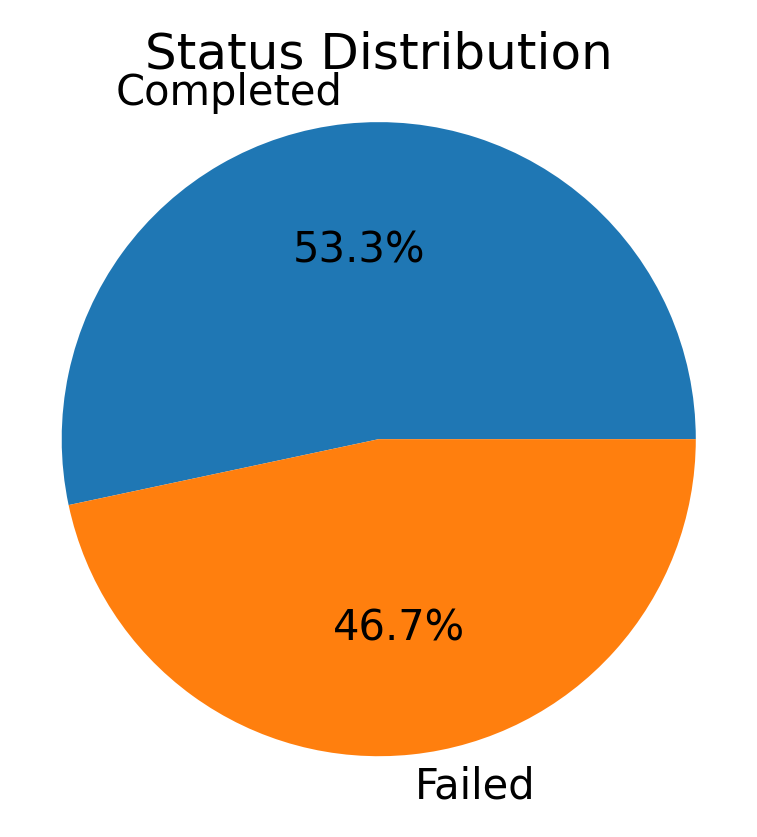
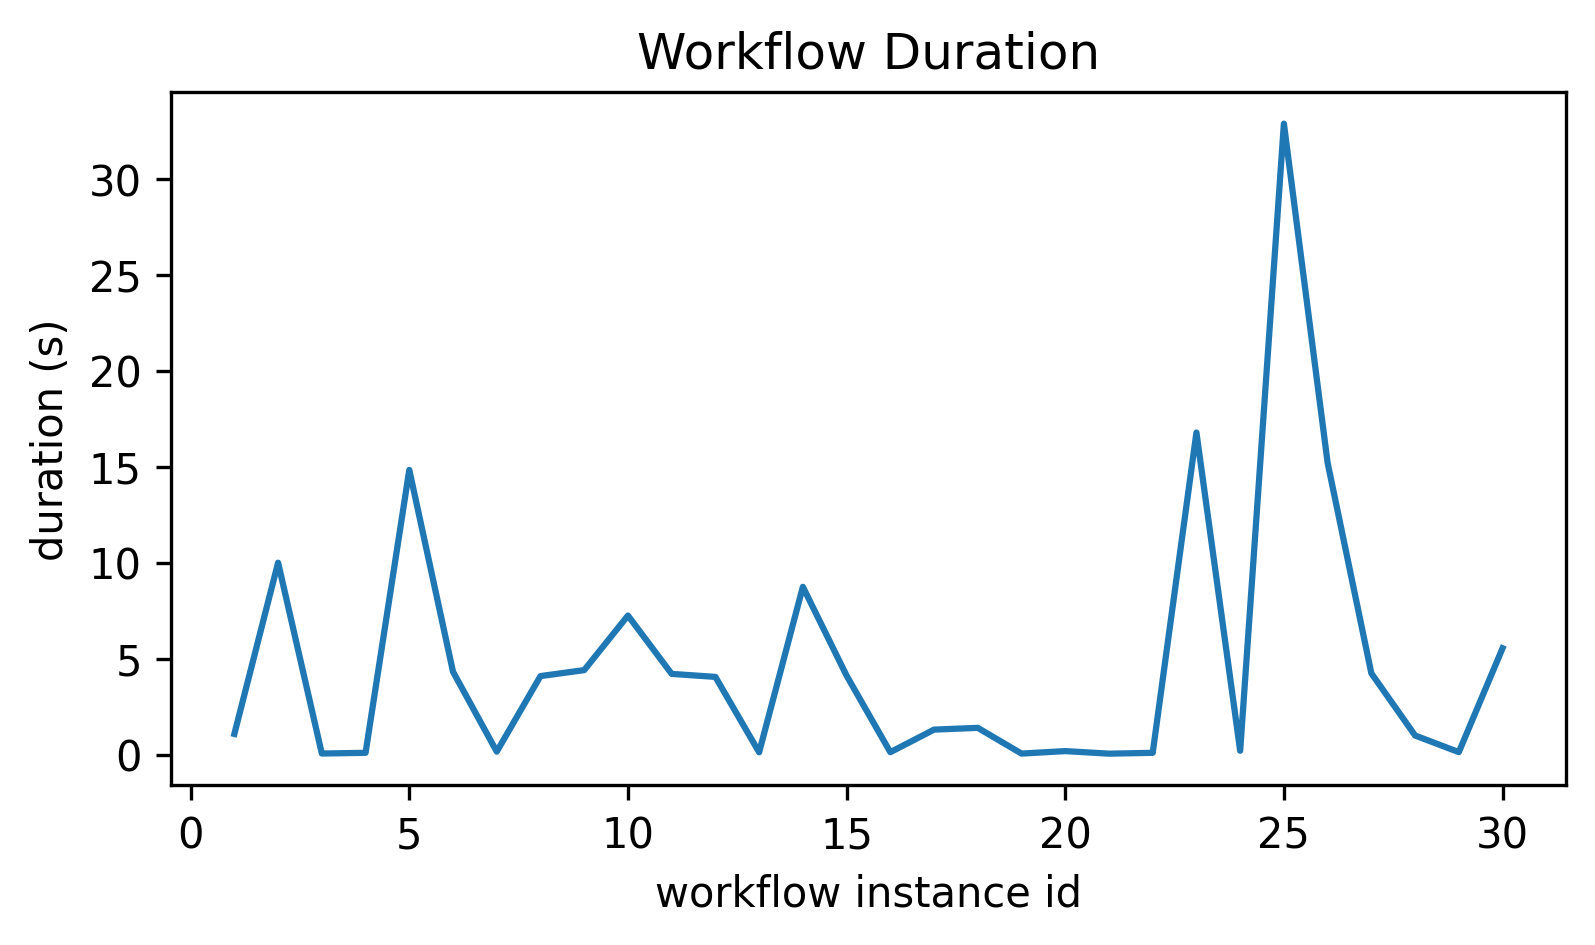
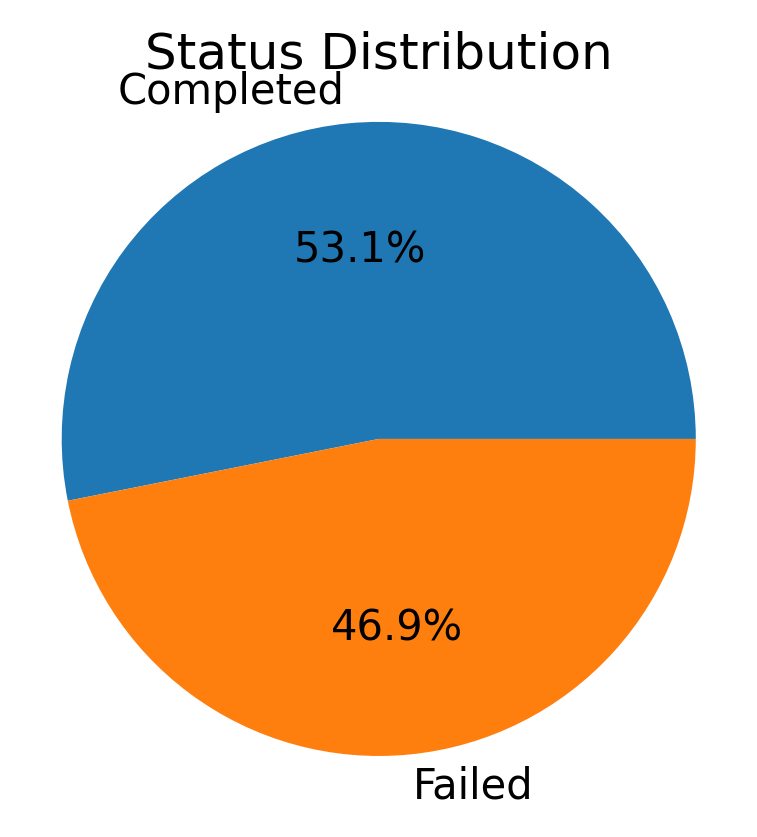
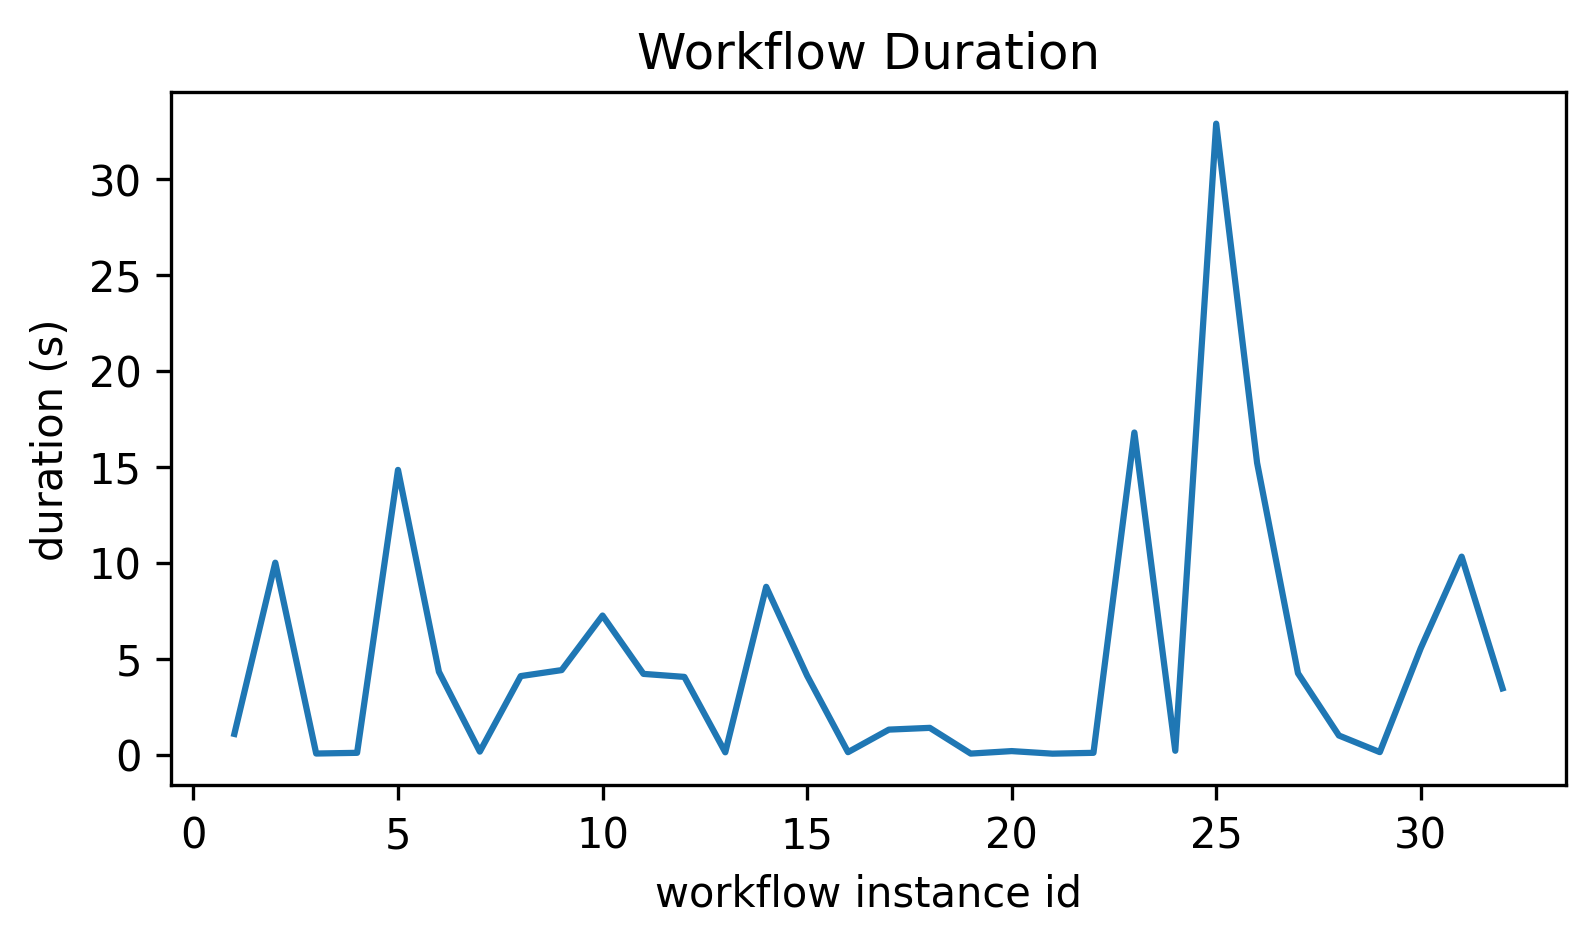

{'id': '1562702123',
 'type': 'page',
 'ari': 'ari:cloud:confluence:998e78d7-2a66-4fc0-809b-b43b4232d4b8:page/1562702123',
 'base64EncodedAri': 'YXJpOmNsb3VkOmNvbmZsdWVuY2U6OTk4ZTc4ZDctMmE2Ni00ZmMwLTgwOWItYjQzYjQyMzJkNGI4OmNvbnRlbnQvMTU2MjcwMjEyMw==',
 'status': 'current',
 'title': 'Transition Dashboard',
 'space': {'id': 406290432,
  'ari': 'ari:cloud:confluence:998e78d7-2a66-4fc0-809b-b43b4232d4b8:space/406290432',
  'key': 'PPA',
  'alias': 'PPA',
  'name': 'Payments Enterprise Architecture',
  'type': 'global',
  'status': 'current',
  '_expandable': {'settings': '/rest/api/space/PPA/settings',
   'metadata': '',
   'identifiers': '',
   'roles': '',
   'icon': '',
   'typeSettings': '',
   'description': '',
   'history': '',
   'operations': '',
   'lookAndFeel': '/rest/api/settings/lookandfeel?spaceKey=PPA',
   'permissions': '',
   'theme': '/rest/api/space/PPA/theme',
   'homepage': '/rest/api/content/406290434'},
  '_links': {'webui': '/spaces/PPA',
   'self': 'https://commb
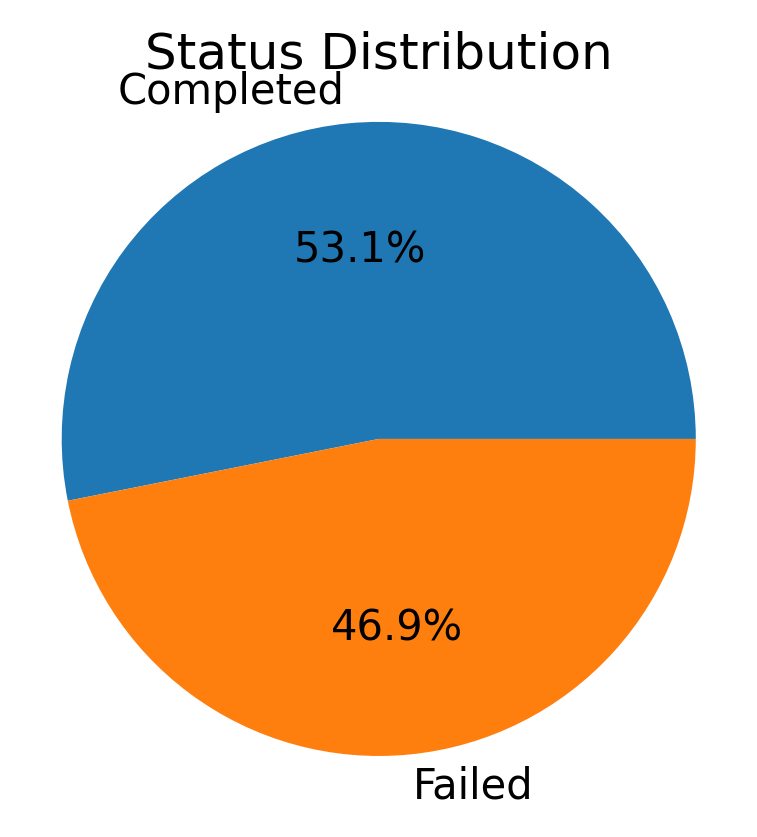
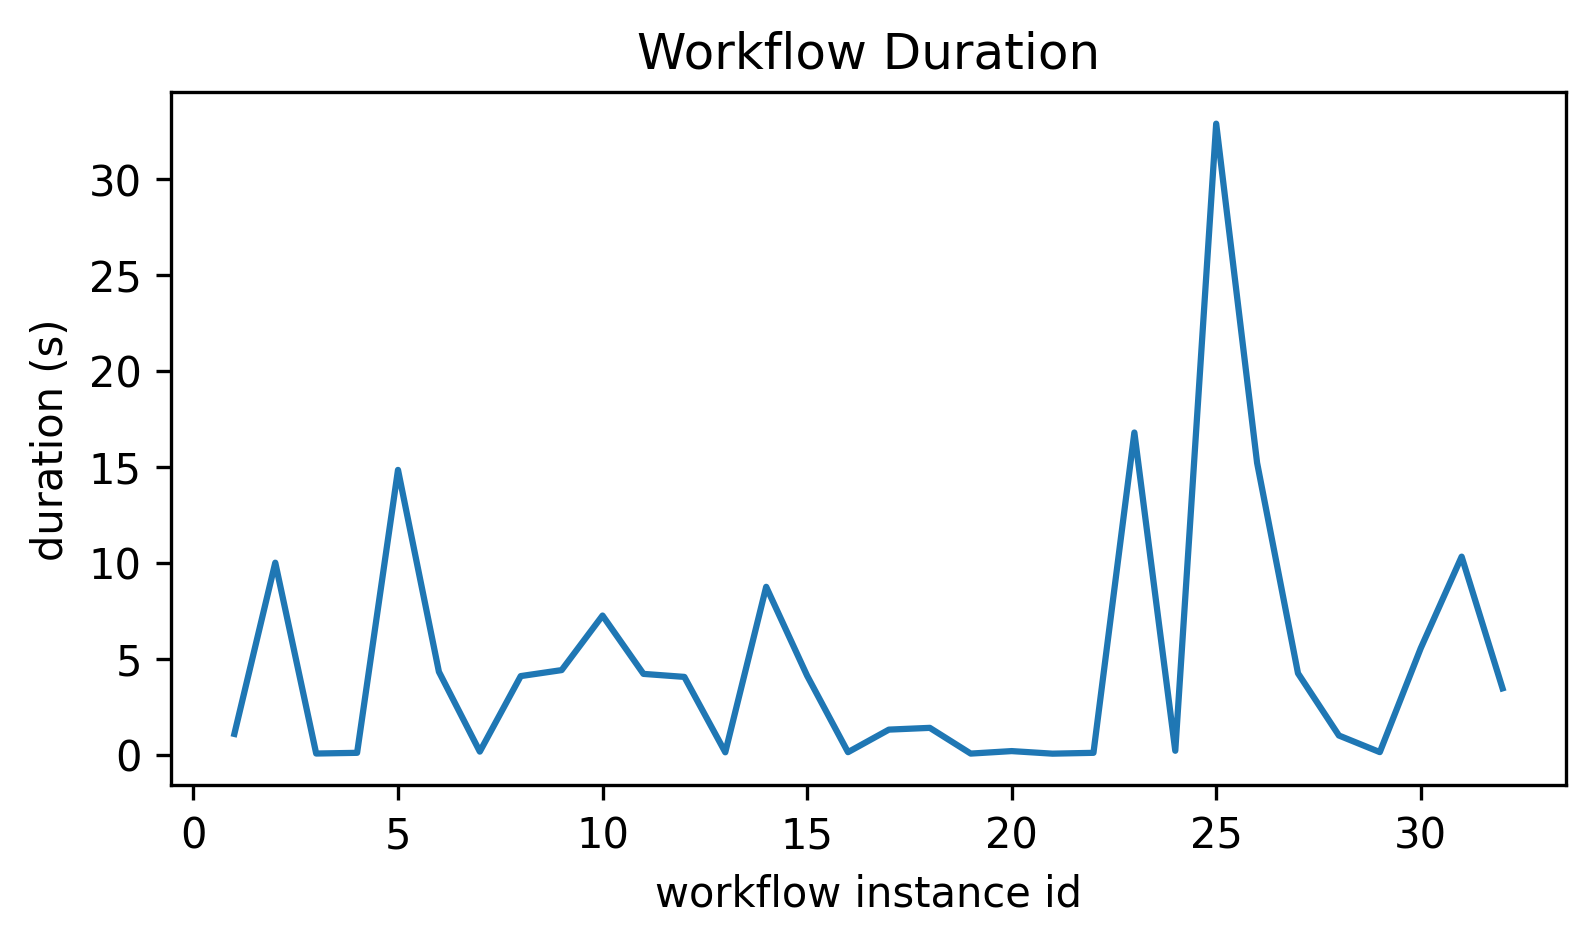

In [49]:
from confluence_client import ConfluenceClient

page_id = "1562702123"
confluence = ConfluenceClient()
confluence.update_page(page_id=page_id, title="Transition Dashboard", content=html)

# Bot

In [50]:
data_dict="""
A workflow instance record is created for each workflow that was run / executed.
The workflow's lifecyce is traced: everytime the status changes, we log it in the workflow_instance_lifecycle table
A workflow consists one or more worksteps. A Workstep Instance is an instantiation of a workstep.
The workstep's lifecyce is traced: everytime the status changes, we log it in the workstep_instance_lifecycle table

Here is the DDL for the workflow management database:

Tables: [('workflow_instance',), ('workflow_instance_lifecycle',), ('workstep_instance',), ('workstep_instance_lifecycle',)]

DDL for table 'workflow_instance':
  ('id', 'INTEGER', 'NO', 'PRI', None, None) -- auto-generated primary key of the table. It's a technical field only, no business meaning.
  ('workflow_id', 'VARCHAR', 'NO', None, None, None) -- ID of the workflow definition. It's meant for human / business consumption.
  ('workflow_name', 'VARCHAR', 'NO', None, None, None) -- name of the workflow definition
  ('status', 'VARCHAR', 'NO', None, None, None) -- status of the workflow instance
  ('start_time', 'TIMESTAMP', 'NO', None, None, None) -- local date time of when the workflow was instantiated / created.
  ('end_time', 'TIMESTAMP', 'YES', None, None, None) -- local date time of when the workflow instance reached one of its final states (see workflow lifecycle below for details)
  ('error_message', 'VARCHAR', 'YES', None, None, None) -- stores the error message if the workflow end up as failed status.
  ('payload_data', 'VARCHAR', 'YES', None, None, None) -- JSON message of the business data that was provided as input for the workflow instance.
CREATE TABLE: CREATE TABLE workflow_instance(id INTEGER, workflow_id VARCHAR NOT NULL, workflow_name VARCHAR NOT NULL, status VARCHAR NOT NULL, start_time TIMESTAMP NOT NULL, end_time TIMESTAMP, error_message VARCHAR, payload_data VARCHAR, PRIMARY KEY(id));

DDL for table 'workflow_instance_lifecycle':
  ('id', 'VARCHAR', 'NO', 'PRI', None, None) -- auto-generated primary key of the table. It's a technical field only, no business meaning.
  ('workflow_instance_id', 'INTEGER', 'YES', None, None, None) -- reference to the workflow instance record
  ('from_state', 'VARCHAR', 'NO', None, None, None) -- the status before the change
  ('to_state', 'VARCHAR', 'NO', None, None, None) -- the status after the change
  ('change_dt', 'TIMESTAMP', 'YES', None, None, None) -- local date time when the status change occurred
  ('changed_by', 'VARCHAR', 'YES', None, None, None) -- user or system that initiated the change
  ('notes', 'VARCHAR', 'YES', None, None, None) -- any notes about the change, which is meant for human consumption
CREATE TABLE: CREATE TABLE workflow_instance_lifecycle(id VARCHAR, workflow_instance_id INTEGER, from_state VARCHAR NOT NULL, to_state VARCHAR NOT NULL, change_dt TIMESTAMP, changed_by VARCHAR, notes VARCHAR, PRIMARY KEY(id), FOREIGN KEY (workflow_instance_id) REFERENCES workflow_instance(id));

DDL for table 'workstep_instance':
  ('id', 'INTEGER', 'NO', 'PRI', None, None) -- auto-generated primary key of the table. It's a technical field only, no business meaning.
  ('workflow_instance_id', 'INTEGER', 'YES', None, None, None) -- points to the workflow_instance record to which this workstep belongs.
  ('step_id', 'VARCHAR', 'NO', None, None, None) -- business level ID of the workstep; meant for human consumption
  ('step_name', 'VARCHAR', 'NO', None, None, None) -- name of the workstep
  ('bian_sd', 'VARCHAR', 'NO', None, None, None) -- identifies which BIAN service domain that owns this step, so that it can be used to raise service management tickets if the step failed.
  ('status', 'VARCHAR', 'NO', None, None, None) -- status of the workstep
  ('start_time', 'TIMESTAMP', 'YES', None, None, None) -- local date time when the workstep was instantiated.
  ('end_time', 'TIMESTAMP', 'YES', None, None, None) -- local date time when the workstep reached one of its final statuses - see work step lifecycle below for details.
  ('attempt_number', 'INTEGER', 'YES', None, None, None) -- if retry (due to technical failure) was attempted, this field records number of retries made.
  ('max_retries', 'INTEGER', 'YES', None, None, None) -- maximum number of retries to be made when encountering technical failures in the workstep.
  ('retry_delay', 'INTEGER', 'YES', None, None, None) -- retry delay in seconds
  ('error_message', 'VARCHAR', 'YES', None, None, None) -- stores the error message if the workstep end up as failed status.
  ('result_data', 'VARCHAR', 'YES', None, None, None) -- JSON message storing the output data of the workstep
  ('payload_data', 'VARCHAR', 'YES', None, None, None) -- JSON message storing the input data of the workstep
CREATE TABLE: CREATE TABLE workstep_instance(id INTEGER, workflow_instance_id INTEGER, step_id VARCHAR NOT NULL, step_name VARCHAR NOT NULL, bian_sd VARCHAR NOT NULL, status VARCHAR NOT NULL, start_time TIMESTAMP, end_time TIMESTAMP, attempt_number INTEGER, max_retries INTEGER, retry_delay INTEGER, error_message VARCHAR, result_data VARCHAR, payload_data VARCHAR, PRIMARY KEY(id), FOREIGN KEY (workflow_instance_id) REFERENCES workflow_instance(id));

DDL for table 'workstep_instance_lifecycle':
  ('id', 'VARCHAR', 'NO', 'PRI', None, None) -- auto-generated primary key of the table. It's a technical field only, no business meaning.
  ('workstep_instance_id', 'INTEGER', 'YES', None, None, None) -- reference to the workstep instance record
  ('from_state', 'VARCHAR', 'NO', None, None, None) -- the status before the change
  ('to_state', 'VARCHAR', 'NO', None, None, None) -- the status after the change
  ('change_dt', 'TIMESTAMP', 'YES', None, None, None) -- local date time when the status change occurred
  ('changed_by', 'VARCHAR', 'YES', None, None, None) -- user or system that initiated the change
  ('notes', 'VARCHAR', 'YES', None, None, None) -- any notes about the change, which is meant for human consumption
CREATE TABLE: CREATE TABLE workstep_instance_lifecycle(id VARCHAR, workstep_instance_id INTEGER, from_state VARCHAR NOT NULL, to_state VARCHAR NOT NULL, change_dt TIMESTAMP, changed_by VARCHAR, notes VARCHAR, PRIMARY KEY(id), FOREIGN KEY (workstep_instance_id) REFERENCES workstep_instance(id));


The following shows the lifecycle status definitions for workflow and workstep, respectively:

# Workflow Status Categories
The system tracks workflows through six possible states:

* Initiated: The workflow has been created but not yet started
* Running: The workflow is actively being processed
* Completed: The workflow finished successfully
* Failed: The workflow encountered an error and stopped
* Cancelled: The workflow was deliberately stopped before completion
* Pending: The workflow is waiting for something (like manual approval)

Business Rules for Workflow Status Changes:

* From "Initiated" → can only go to "Running"
* From "Running" → can go to "Failed," "Completed," "Pending," or "Cancelled"
* From "Failed" → can go to "Running" (retry) or "Cancelled"
* From "Pending" → can go to "Completed" or "Cancelled"
* "Completed" and "Cancelled" are final states (no further changes allowed)

# Work Step Status Categories
Individual work steps within workflows have seven possible states:

* Initiated: The step has been created but not started
* Running: The step is currently being executed
* Completed: The step finished successfully
* Failed: The step encountered an error
* Cancelled: The step was deliberately stopped
* Waiting: The step is paused, waiting for external conditions
* Pending Completion: The step is done but awaiting final confirmation

Business Rules for Work Step Status Changes:

* From "Initiated" → can only go to "Running"
* From "Running" → can go to "Waiting," "Failed," "Completed," "Pending Completion," or "Cancelled"
* From "Waiting" → can go to "Running" or "Cancelled"
* From "Failed" → can go to "Running" (retry) or "Cancelled"
* From "Pending Completion" → can go to "Completed" or "Cancelled"
* "Completed" and "Cancelled" are final states
"""


In [51]:
from langchain.tools import tool
from typing import List, Dict, Any
from pydantic import conint
from sqlalchemy import text
from datetime import datetime

from workflow_mgmt import Session
import utils
from utils import client

@tool
def execute_sql(query: str) -> List[Any]:
    """
    It executes the SQL query in the workflow management database and return the query results.
    Args:
        query (str): SQL query to be executed
    Returns:
        result (str): List of records that the SQL query returned from database. If exception occurred, then the list will contain only one element storing the exception
    """
    result = []
    session = Session()
    try:    
        response = session.execute(text(query))
        for row in response:
            result.append(row)
    except Exception as e:
        result.append(e)

    session.close()
    return result

from langchain.tools import Tool
import json

tools = [
        Tool(
            name="get_current_date_time",
            func=lambda query: datetime.now().strftime("%A %d %B %Y at %H:%M:%S"),
            description="Get the current date, time and day of week. It answers the question of today's date, day of week, etc."
        ),
        execute_sql
    ]   

from langchain_openai import ChatOpenAI
from langchain.schema import SystemMessage, HumanMessage, AIMessage
from langchain.tools import Tool
from langchain.agents import AgentExecutor, create_openai_tools_agent
from langchain.prompts import ChatPromptTemplate, MessagesPlaceholder
import utils

SYSTEM_PROMPT=f"""You are a database agent to generate and run queries in the workflow database using the execute_sql() tool call.
The database data dictionary is provided in below block of code, which details the data entities of workflow instance, workstep instance
and their lifecycle definitions and logs. 
```
{data_dict}
```
Use the above data dictionary as your database knowledge to answer the user's queries by following the following steps:
1. if the user query involves the current date and time, then run the get_current_date_time tool call
2. identify the database tables to use to anser the user query
3. check the data dictionary for details of the tables, their definition and their relationships
4. generate the SQL statement to be executed.
5. run the generated SQL statement using the execute_sql tool call, format and return the results to user
Speak like Davy Jones.
"""

chat_history = []
agent_scratchpad = []

# Create prompt template
prompt = ChatPromptTemplate.from_messages([
    ("system", SYSTEM_PROMPT),
    MessagesPlaceholder(variable_name="chat_history"),
    ("user", "{input}"),
    MessagesPlaceholder(variable_name="agent_scratchpad"),
])

# Create the agent
llm = ChatOpenAI(
    temperature=0.2,
    model= utils.CHAT_MODEL,
    openai_api_key=utils.GENAI_API_KEY,
    base_url=utils.GENAI_API_URL
)
agent = create_openai_tools_agent(llm, tools, prompt)

# Create the agent executor
agent_executor = AgentExecutor(
    agent=agent,
    tools=tools,
    verbose=False
) 

def chat(user_prompt:str)->str:
    result = agent_executor.invoke({
        "input": user_prompt,
        "chat_history": chat_history 
    })
    response = result["output"]

    # Update chat history
    chat_history.extend([
        HumanMessage(content=user_prompt),
        AIMessage(content=response)
    ])

    return response

## Chat

In [52]:
q="tell me about workflows and worksteps"
print(chat(q))

Arrr, let me tell ye about workflows and worksteps in this here system!

A workflow be a sequence of tasks or steps that must be completed to achieve a business goal. Each time a workflow is run, a workflow instance is created, and its journey through various states—like Initiated, Running, Completed, Failed, Cancelled, or Pending—is tracked in the system. Every change in its status is logged for the record.

Within each workflow, there be worksteps—individual tasks that make up the whole process. Each workstep also has its own instance, and it too sails through states such as Initiated, Running, Completed, Failed, Cancelled, Waiting, or Pending Completion. The fate of each workstep is tracked, and every change in its status is logged as well.

In short:
- Workflows be the big voyages, and worksteps be the tasks that make up the journey.
- Both are tracked closely, with every twist and turn logged for posterity.

If ye want to see specific workflows or worksteps, or their current statu

In [53]:
user_prompt = "show me all the failed worksteps (and all their fields) that were created yesterday afternoon, grouped by the BIAN SD. Show your results as a table "
# user_prompt = "retrieve all workstep instances with workflow_instance_id=17, and generate python code (using plotly) to plot gannt chart and make sure the bars are staggered by the start_time"
print(chat(user_prompt))

Here be the failed worksteps created yesterday afternoon (from 12:00 to 18:00), grouped by their BIAN Service Domain (BIAN SD):

| id | workflow_instance_id | step_id         | step_name         | bian_sd | status | start_time                | end_time                  | attempt_number | max_retries | retry_delay | error_message                              | result_data | payload_data |
|----|---------------------|-----------------|-------------------|---------|--------|---------------------------|---------------------------|---------------|-------------|-------------|--------------------------------------------|-------------|--------------|
| 74 | 25                  | CtaOnboarding   | onboard_merchant  | CTA     | Failed | 2025-08-05 13:04:42.618675| 2025-08-05 13:04:45.626691| 4             | 3           | 1           | Took too long.                             | NULL        | ...          |
| 61 | 18                  | Step_1          | onboard_merchant  | MAF     | Failed | 202

In [28]:
import plotly.express as px
import pandas as pd

# Prepare the data
data = [
    {
        "Task": "MafOnboarding (MAF)",
        "Start": "2025-08-05 12:37:34.595901",
        "Finish": "2025-08-05 12:37:34.616953"
    },
    {
        "Task": "LinkCustomerProduct (CPSD)",
        "Start": "2025-08-05 12:37:34.648036",
        "Finish": "2025-08-05 12:37:34.658319"
    },
    {
        "Task": "CreatIpbParties (IPB)",
        "Start": "2025-08-05 12:37:34.684310",
        "Finish": "2025-08-05 12:37:34.696445"
    },
    {
        "Task": "CtaOnboarding (CTA)",
        "Start": "2025-08-05 12:37:34.718948",
        "Finish": "2025-08-05 12:37:34.731229"
    }
]

df = pd.DataFrame(data)
df['Start'] = pd.to_datetime(df['Start'])
df['Finish'] = pd.to_datetime(df['Finish'])

fig = px.timeline(
    df,
    x_start="Start",
    x_end="Finish",
    y="Task",
    color="Task",
    title="Gantt Chart for Workflow Instance 17"
)

fig.update_yaxes(autorange="reversed")  # Tasks from top to bottom
fig.update_layout(
    xaxis_title="Time",
    yaxis_title="Workstep",
    showlegend=False,
    bargap=0.2,
    height=400
)
fig.show()

# Decorator

In [33]:
import functools

def my_decorator(func):
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        return my_func(*args, **kwargs)
    
    return wrapper

def my_func(data:str)->str:
    result = f"myfunc running: {data}"
    print(result)
    return result

@my_decorator
def your_func(data:str)->str:
    result = f"yourfunc running: {data}"
    print(result)
    return result

In [34]:
my_func("hello")

myfunc running: hello


'myfunc running: hello'

In [35]:
your_func("world")

myfunc running: world


'myfunc running: world'